In [13]:
from sklearn.model_selection import train_test_split
import pandas as pd
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, explained_variance_score
import matplotlib.pyplot as plt
from numpy import clip, column_stack, argmax
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.neural_network import MLPClassifier


In [58]:

data = pd.read_csv('/Users/mariacarolina/Documents/IST/PYFUME_TUTORIAL/NN_SKLEARN/wbco.csv',header=None, names=["x1","x2","x3","x4","x5","x6","x7","x8","x9","y"])

var_names = data.columns[:-1].tolist()

# Convert all columns to numeric, coercing errors to NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Drop any rows with missing values (NaNs)
data = data.dropna()

# Separate features (X) and target (y)
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()  

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/mariacarolina/opt/anaconda3/envs/pyfume_fuzzy/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mariacarolina/opt/anaconda3/envs/pyfume_fuzzy/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mariacarolina/opt/anaconda3/envs/pyfume_fuzzy/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/mariacarolina/opt/anaconda3/envs/pyfume_fuzzy/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iter

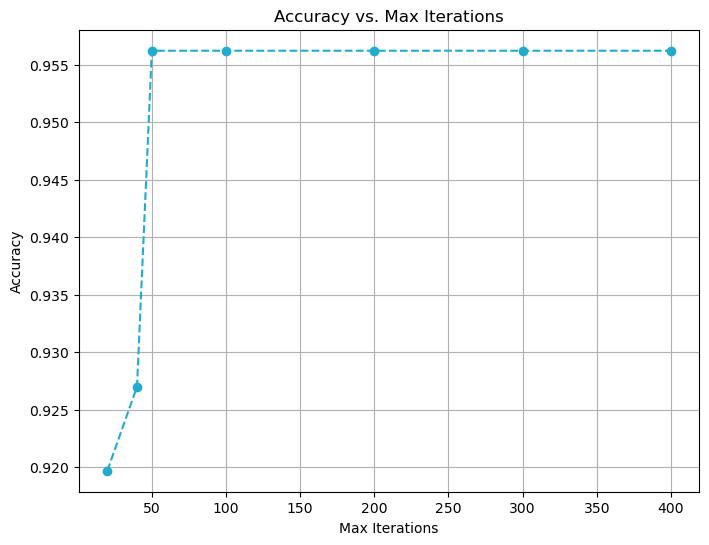

In [65]:
# Define the max_iter values to test
max_iter_values = [20, 40, 50, 100, 200, 300, 400]
accuracy_list = []

# Loop over different max_iter values
for max_iter in max_iter_values:
    # Train the model with the current max_iter
    regr = MLPClassifier(hidden_layer_sizes=(10,10), random_state=42, max_iter=max_iter, learning_rate_init=0.01)
    regr.fit(X_train, y_train)
    
    # Get model predictions
    y_pred = regr.predict(X_test)
    
    # Calculate accuracy and store it
    acc_score = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc_score)

# Plot accuracy vs max_iter
plt.figure(figsize=(8, 6))
plt.plot(max_iter_values, accuracy_list, marker='o', linestyle='--', color='#21ABCD')  # IST blue
plt.title('Accuracy vs. Max Iterations')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

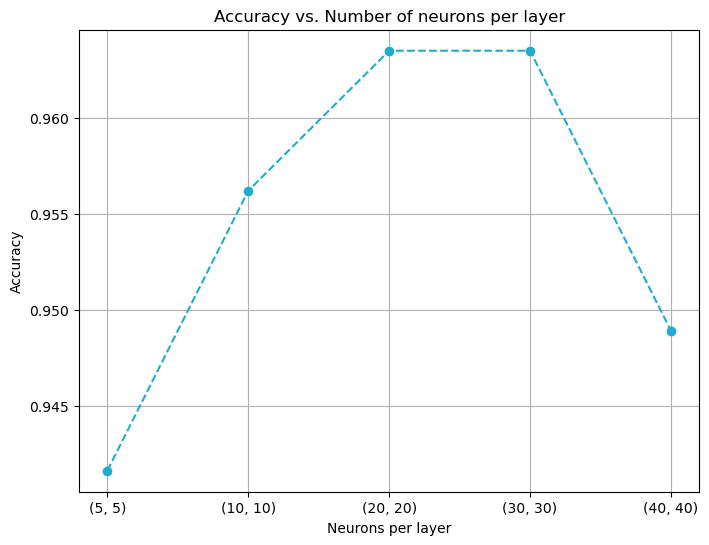

In [63]:
# Define the hidden layer configurations to test
hidden_layer_configs = [(5,5), (10,10), (20,20), (30,30), (40,40)]  # You can add more configurations
accuracy_list = []

# Loop over different hidden layer configurations
for hidden_layers in hidden_layer_configs:
    # Train the model with the current configuration of hidden layers
    regr = MLPClassifier(hidden_layer_sizes=hidden_layers, random_state=42, max_iter=500, learning_rate_init=0.01)
    regr.fit(X_train, y_train)
    
    # Get model predictions
    y_pred = regr.predict(X_test)
    
    # Calculate accuracy and store it
    acc_score = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc_score)

# Convert the hidden layer configs to string for labeling purposes
hidden_layer_labels = [str(layers) for layers in hidden_layer_configs]

# Plot accuracy vs number of hidden layers
plt.figure(figsize=(8, 6))
plt.plot(hidden_layer_labels, accuracy_list, marker='o', linestyle='--', color='#21ABCD')
plt.title('Accuracy vs. Number of neurons per layer')
plt.xlabel('Neurons per layer')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [55]:
# %% Train model
regr = MLPClassifier(hidden_layer_sizes=(10,10),random_state=42, max_iter=200)
regr.fit(X_train, y_train)

# %% Get model predictions
y_pred = regr.predict(X_test)

# %% Compute classification metrics
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.953
Kappa Score: 0.901


/Users/mariacarolina/opt/anaconda3/envs/pyfume_fuzzy/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [54]:
'''# %% Cluster the input-output space
cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=10)
clust_centers, part_matrix, _ = cl.cluster(method='fcm')

# %% Estimate membership functions parameters
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

# %% Estimate consequent parameters
ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

# %% Build first-order Takagi-Sugeno model
modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

# %% Get model predictions
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

# %% Compute classification metrics
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))
'''